# Classical Simulation

Many quantum information subroutines are reversible classical operations. The catch is that they are operated on superpositions of classical bitstrings. However, we can unit test these operations by checking against specific bitstrings through the `call_classically` bloqs protocol.

In [1]:
from qualtran.bloqs.basic_gates import CNOT

cnot = CNOT()
cnot.call_classically(ctrl=1, target=0)

(1, 1)

## Interface

The primary way to simulate the classical action of a bloq is through the `Bloq.call_classically` method. This takes classical values for each left- or thru-register and returns a classical value for each right- or thru-register (in the order of the bloq's signature). 

The functionality for this method is contained in the `qualtran.simulation.classical_sim` module. 

In [2]:
import itertools
for c, t in itertools.product([0,1], repeat=2):
    out_c, out_t = CNOT().call_classically(ctrl=c, target=t)
    print(f'{c}{t} -> {out_c}{out_t}')

00 -> 00
01 -> 01
10 -> 11
11 -> 10


## Additional Functionality

### Consistent classical action

The primary method of testing the classical action of a bloq is comparing the classical action from the bloq's decomposition with its directly annotated, reference action. For example: the `Add` is annotated with a method override that directly adds two numbers. This is the reference classical action for addition


In [3]:
from qualtran import QUInt
from qualtran.bloqs.arithmetic import Add

add = Add(QUInt(8))
add.call_classically(a=5, b=7)

(5, 12)

The `Add` bloq also is annotated with a decomposition that we would like to validate. We can check various input/output pairs against the reference implementation to gain confidence that the decomposition is correct.

In [4]:
import numpy as np
rs = np.random.RandomState(seed=52)

add_cbloq = add.decompose_bloq()

for _ in range(10):
    a = rs.randint(256)
    b = rs.randint(256)
    ref_vals = add.call_classically(a=a, b=b)
    decomp_vals = add_cbloq.call_classically(a=a, b=b)
    assert ref_vals == decomp_vals
    print('✓', end='')

✓✓✓✓✓✓✓✓✓✓

### `assert_consistent_classical_action`

The idea above is encapsulated in an exhaustive testing function. You can use properties of the quantum data types involved to make the function quite general

In [5]:
import qualtran.testing as qlt_testing

dtype = QUInt(2)
qlt_testing.assert_consistent_classical_action(
    bloq=Add(dtype), 
    a=dtype.get_classical_domain(),
    b=dtype.get_classical_domain(),
)
print('✓')

✓


### Printing truth tables

There are functions provided to quickly print the truth table of a bloq.

In [6]:
from qualtran.simulation.classical_sim import get_classical_truth_table, format_classical_truth_table
from qualtran.bloqs.arithmetic import Add
from qualtran import QUInt

add = Add(QUInt(2))
print(format_classical_truth_table(*get_classical_truth_table(add)))

a  b  |  a  b
--------------
0, 0 -> 0, 0
0, 1 -> 0, 1
0, 2 -> 0, 2
0, 3 -> 0, 3
1, 0 -> 1, 1
1, 1 -> 1, 2
1, 2 -> 1, 3
1, 3 -> 1, 0
2, 0 -> 2, 2
2, 1 -> 2, 3
2, 2 -> 2, 0
2, 3 -> 2, 1
3, 0 -> 3, 3
3, 1 -> 3, 0
3, 2 -> 3, 1
3, 3 -> 3, 2


## Implementation

The `qualtran.simulation.classical_sim` functions rely on `Bloq.on_classical_vals` overrides to implement the protocol. This method encodes a bloq's classical action.

Bloq authors should aim to always provide a `on_classical_vals` override if the bloq implements a classical function. The override on high-level bloqs can serve as a reference implementation for testing decompositions, see above.

A simple classical gate is the controlled not. This flips the target bit if `ctrl` is set. We'll implement `on_classical_vals` to encode this behavior

In [7]:
from typing import *

import numpy as np
from attrs import frozen
from numpy.typing import NDArray

from qualtran import Bloq, BloqBuilder, Register, Signature, Side
from qualtran.drawing import show_bloq

In [8]:
@frozen
class CNOTExample(Bloq):
    @property
    def signature(self) -> 'Signature':
        return Signature.build(ctrl=1, target=1)

    def on_classical_vals(
        self, ctrl: NDArray[np.uint8], target: NDArray[np.uint8]
    ) -> Dict[str, NDArray[np.uint8]]:
        target_out = (ctrl + target) % 2
        return {'ctrl': ctrl, 'target': target_out}

We can call the Bloq on classical inputs by using `Bloq.call_classically()`. Below, we inspect the truth table.

In [9]:
my_cnot = CNOTExample()
print(format_classical_truth_table(*get_classical_truth_table(my_cnot)))

ctrl  target  |  ctrl  target
------------------------------
0, 0 -> 0, 0
0, 1 -> 0, 1
1, 0 -> 1, 1
1, 1 -> 1, 0


## Properties and Relations

### Drawing

We can draw the flow of classical values as well using `ClassicalSimGraphDrawer`

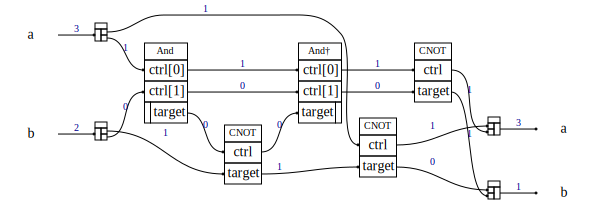

In [10]:
from qualtran.drawing import ClassicalSimGraphDrawer

drawer = ClassicalSimGraphDrawer(Add(QUInt(2)).decompose_bloq(), vals=dict(a=3, b=2))
drawer.get_svg()

### Quantum Data Types

To convert back and forth between classical values and bitstrings, we use the `QDType.to_bits` and `QDType.from_bits` functions. Qualtran uses a big-endian convention. The most significant bit is at index 0.

In [11]:
QUInt(8).to_bits(254)

[1, 1, 1, 1, 1, 1, 1, 0]

### QFxp classical values

Due to technical limitations, `QFxp` classical values are represented as fixed-width integers.
See the class docstring for QFxp for precise details.
To convert from true floating point values to this representation and vice-versa,
users can use `QFxp.to_fixed_width_int` and `QFxp.float_from_fixed_width_int` respectively.

In [12]:
from qualtran import QFxp

@frozen
class DoubleFxp(Bloq):
    """Bloq with a QFxp of 4 bits (0 int, 4 frac).
    
    This bloq doubles the input value inplace, discarding any overflow
    """
    num_frac: int = 4
    
    @property
    def signature(self) -> Signature:
        return Signature.build_from_dtypes(x=QFxp(self.num_frac, self.num_frac))
    
    def on_classical_vals(self, x) -> dict[str, 'ClassicalValT']:
        """Double the input value, discarding overflow"""
        return {'x': (x * 2) % (2**self.num_frac)}


bloq_with_qfxp = DoubleFxp()
x_float = 0.25
x_as_int = QFxp(4, 4).to_fixed_width_int(x_float)
(x_out_as_int,) = bloq_with_qfxp.call_classically(x=x_as_int)
x_out_float = QFxp(4, 4).float_from_fixed_width_int(x_out_as_int)
assert x_out_float == 0.5